In [221]:
import os,sys

module_paths = [
    '../external/deepknockoffs/DeepKnockoffs/DeepKnockoffs',  # kfilter
    '../external/deepknockoffs/examples'
]
module_paths = [os.path.abspath(os.path.join(x)) for x in module_paths]
for module_path in module_paths:
    if module_path not in sys.path:
        sys.path.append(module_path)

from DeepKnockoffs.gaussian import GaussianKnockoffs
from DeepKnockoffs.kfilter import kfilter

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
import torchvision.datasets as datasets

%load_ext autoreload
%autoreload 2
    
import model
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [222]:
seed = 0
gpu_id = '0'
data_root = './data'
n_workers = 8
lr = 0.0002

batch_size = 100
image_size = 28
n_classes = 10
train = True

In [223]:
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
np.random.seed(seed)

os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'using {device}')

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(image_size),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,)),
    # for mlp vae
    torchvision.transforms.Lambda(lambda x: x.view(-1)),
])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root=data_root, download=True, train=True, transform=transforms),
    batch_size=batch_size, shuffle=True, num_workers=n_workers, pin_memory=True)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root=data_root, download=True, train=False, transform=transforms),
    batch_size=batch_size, shuffle=True, num_workers=n_workers, pin_memory=True)

using cuda


In [63]:
latent_size = 20
enc_sizes = [image_size*image_size,500,latent_size]
dec_sizes = [latent_size,500,image_size*image_size]
vae = model.VAE(enc_sizes, dec_sizes)
classifier = model.LogisticRegression(latent_size,n_classes)

if not train:
    vae.load_state_dict(torch.load('vae.pt'))
    classifier.load_state_dict(torch.load('classifier.pt'))
vae.to(device)
classifier.to(device)

vae, classifier

(VAE(
   (encoder): Encoder(
     (mlp): Sequential(
       (0): Sequential(
         (0): Linear(in_features=784, out_features=500, bias=True)
         (1): Tanh()
       )
     )
     (fc_mu): Linear(in_features=500, out_features=20, bias=True)
     (fc_logvariance): Linear(in_features=500, out_features=20, bias=True)
   )
   (stochasticlayer): StochasticLayer()
   (decoder): Decoder(
     (mlp): Sequential(
       (0): Sequential(
         (0): Linear(in_features=20, out_features=500, bias=True)
         (1): Tanh()
       )
     )
     (last_layer): Sequential(
       (0): Linear(in_features=500, out_features=784, bias=True)
       (1): Sigmoid()
     )
   )
 ),
 LogisticRegression(
   (linear): Linear(in_features=20, out_features=10, bias=True)
 ))

In [65]:
## Training VAE
# 
optimizer_vae = torch.optim.Adam(vae.parameters(),lr=lr)

n_epochs = 50
log_interval = 100

for epoch in range(n_epochs):
    running_loss = 0
    for it, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        mu, logvariance, z, y = vae(images)
        loss = -model.VAE.variational_objective(images, mu, logvariance, z, y)

        optimizer_vae.zero_grad()
        loss.backward()
        optimizer_vae.step()

        running_loss += loss
        if it % log_interval == log_interval-1:
            print(f'[{epoch+1} {it+1}] loss: {running_loss/log_interval}')
            running_loss = 0.0

print('Finished Training')
torch.save(vae.state_dict(), "./vae.pt")

Finished Training


In [68]:
def test_model(vae, dataloader, device):
    elbo_avg = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        out = vae(x)
        elbo_avg += model.VAE.variational_objective(x, *out)
    return elbo_avg/len(dataloader)

print(f"Training set ELBO = {test_model(vae, train_loader, device)}")
print(f"Test set ELBO     = {test_model(vae, test_loader, device)}")

Training set ELBO = 10209.244140625
Test set ELBO     = 10184.6650390625


In [95]:
## Training a simple classifier on latent code to classify digits
# 

def evaluate(classifier, vae, test_loader, device):
    classifier.eval()
    vae.eval()
    criterion = F.cross_entropy
    with torch.no_grad():
        test_loss = 0
        correct   = 0
        for x, y in test_loader:
            x, y  = x.to(device), y.to(device)
            _,_,z,_ = vae(x)
            output = classifier(z)
            test_loss += criterion(output, y, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        correct = 100. * correct / len(test_loader.dataset)
    vae.train()
    classifier.train()
    return test_loss, correct

criterion = nn.CrossEntropyLoss()
optimizer_classifier = torch.optim.Adam(classifier.parameters(),lr=lr)

n_epochs = 20

for epoch in range(n_epochs):
    for it, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        mu,logvariance,z,_ = vae(images)
        out = classifier(z)
        loss = criterion(out, labels)
        
        optimizer_classifier.zero_grad()
        loss.backward()
        optimizer_classifier.step()
        
        if it % log_interval == log_interval-1:
            print(f'[{epoch+1}/{n_epochs}]\t'
                  f'[{(it+1)*batch_size}/{len(train_loader.dataset)} ({100.*(it+1)/len(train_loader):.0f}%)]\t'
                  f'loss={loss.item():.4}')
    
    test_loss, correct = evaluate(classifier, vae, test_loader, device)

    print(f'[{epoch+1}/{n_epochs}]\t'
            f'Average Loss: {test_loss:.4}\t'
            f'Accuracy: {correct}/{len(test_loader.dataset)} ({correct:.0f}%)')
    
print('Finished Training')
torch.save(classifier.state_dict(), "./classifier.pt")

[1/20]	[10000/60000 (17%)]	loss=0.351
[1/20]	[20000/60000 (33%)]	loss=0.2405
[1/20]	[30000/60000 (50%)]	loss=0.4284
[1/20]	[40000/60000 (67%)]	loss=0.3827
[1/20]	[50000/60000 (83%)]	loss=0.4687
[1/20]	[60000/60000 (100%)]	loss=0.4474
[1/20]	Average Loss: 0.3984	Accuracy: 88.03/10000 (88%)
[2/20]	[10000/60000 (17%)]	loss=0.2514
[2/20]	[20000/60000 (33%)]	loss=0.555
[2/20]	[30000/60000 (50%)]	loss=0.5413
[2/20]	[40000/60000 (67%)]	loss=0.2609
[2/20]	[50000/60000 (83%)]	loss=0.5364
[2/20]	[60000/60000 (100%)]	loss=0.4271
[2/20]	Average Loss: 0.3988	Accuracy: 88.13/10000 (88%)
[3/20]	[10000/60000 (17%)]	loss=0.451
[3/20]	[20000/60000 (33%)]	loss=0.3899
[3/20]	[30000/60000 (50%)]	loss=0.354
[3/20]	[40000/60000 (67%)]	loss=0.4416
[3/20]	[50000/60000 (83%)]	loss=0.3701
[3/20]	[60000/60000 (100%)]	loss=0.3661
[3/20]	Average Loss: 0.3968	Accuracy: 88.14/10000 (88%)
[4/20]	[10000/60000 (17%)]	loss=0.3939
[4/20]	[20000/60000 (33%)]	loss=0.5331
[4/20]	[30000/60000 (50%)]	loss=0.4164
[4/20]	[40000/

In [103]:
binaryclassifier = model.LogisticRegression(latent_size,1)
binaryclassifier.to(device)
binaryclassifier

LogisticRegression(
  (linear): Linear(in_features=20, out_features=1, bias=True)
)

In [135]:
## Training a simple classifier on latent code to classify 1 digit
# 


digit = 5
make_label = lambda y: (y == digit).float().view(-1,1)
    
def evaluate(classifier, vae, test_loader, device):
    classifier.eval()
    vae.eval()
    criterion = F.binary_cross_entropy_with_logits
    with torch.no_grad():
        test_loss = 0
        correct   = 0
        for x, y in test_loader:
            y = make_label(y)
            x, y  = x.to(device), y.to(device)
            _,_,z,_ = vae(x)
            output = classifier(z)
            test_loss += criterion(output, y, reduction='sum').item()
            pred = (torch.sigmoid(output) > 0.5).float()
            correct += pred.eq(y.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        correct = 100. * correct / len(test_loader.dataset)
    vae.train()
    classifier.train()
    return test_loss, correct

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(binaryclassifier.parameters(),lr=lr)

n_epochs = 50

for epoch in range(n_epochs):
    for it, (images, labels) in enumerate(train_loader):
        labels = make_label(labels)
        images, labels = images.to(device), labels.to(device)
        
        mu,logvariance,z,_ = vae(images)
        out = binaryclassifier(z)
        loss = criterion(out, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if it % log_interval == log_interval-1:
            print(f'[{epoch+1}/{n_epochs}]\t'
                  f'[{(it+1)*batch_size}/{len(train_loader.dataset)} ({100.*(it+1)/len(train_loader):.0f}%)]\t'
                  f'loss={loss.item():.4}')
    
    test_loss, correct = evaluate(binaryclassifier, vae, test_loader, device)

    print(f'[{epoch+1}/{n_epochs}]\t'
            f'Average Loss: {test_loss:.4}\t'
            f'Accuracy: {correct}/{len(test_loader.dataset)} ({correct:.0f}%)')
    
print('Finished Training')
torch.save(binaryclassifier.state_dict(), f"./binaryclassifierfor{digit}.pt")

Finished Training


In [120]:
## knockoff filter on latent space 


from sklearn import preprocessing
from glmnet import LogitNet

def lasso_stats(X,Xk,y,alpha=0.1,scale=True):
    #
    # W: lasso difference coefficient
    # Z: 
    #
    X  = X.astype("float")
    Xk = Xk.astype("float")
    p = X.shape[1]
    if scale:
        X_concat = preprocessing.scale(np.concatenate((X,Xk),1))
    else:
        X_concat = np.concatenate((X,Xk),1)
    cols_order = np.random.choice(X_concat.shape[1],X_concat.shape[1],replace=False)
    m = LogitNet(alpha=0.1, n_splits=3)
    m.fit(X_concat[:,cols_order].copy(), y.copy())
    Z = np.zeros((2*p,))
    Z[cols_order] = m.coef_.squeeze()
    W = np.abs(Z[0:p]) - np.abs(Z[p:(2*p)])
    return W.squeeze(), Z


In [273]:
# load pretrained vae / binary classifier 
vae.load_state_dict(torch.load('vae.pt'))
vae.to(device)
binaryclassifier.load_state_dict(torch.load(f'./binaryclassifierfor{digit}.pt'))
binaryclassifier.to(device)


train_loader_singleton = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root=data_root, download=True, train=True, transform=transforms),
    batch_size=1, shuffle=True, num_workers=n_workers, pin_memory=True)


q = 0.3
n_samples = 1

Ws = []

for i in [1,2,3]:
    print(i)
    X = []
    X_k = []
    Y = []

    for it, (images, labels) in enumerate(train_loader_singleton):
        if it > 100000*i + 99999:
            break
        if it < 100000*i:
            continue

        labels = make_label(labels)
        images, labels = images.to(device), labels.to(device)
        mu,logvariance,z,_ = vae(images)

        # generate samples from q(z|x)
        Z = model.sample_gaussian(mu.repeat(n_samples,1),logvariance.repeat(n_samples,1))
        # behavior of logistic model p(y|z)
        y = (torch.sigmoid(binaryclassifier(Z))>0.5).int()
        # to np
        Z = torch_to_np(Z)
        y = torch_to_np(y)
        # 1) Generate knockoffs X_k
        mu = torch_to_np(mu)
        logvariance = torch_to_np(logvariance)
        Sigma = np.diag(np.exp(logvariance.reshape(-1)))
        knockoff_generator = GaussianKnockoffs(Sigma, method='equi', mu=mu) # method='equi' too slow    
        Z_k = knockoff_generator.generate(Z)

        X.append(Z)
        X_k.append(Z_k)
        Y.append(y)

    
    X = np.concatenate(X,axis=0)
    X_k = np.concatenate(X_k,axis=0)
    Y = np.concatenate(Y,axis=0)
    
    
    # 2) Compute pairwise statistics W
    W, _ = lasso_stats(X,X_k,Y,alpha=0,scale=False)
    # 3) Compute threshold 
    t = kfilter(W, q=0.2)
    print(f'threshold: {t}')
    # 4) Perform Test
    S = np.where(W >= t)[0]
    print(S)
    print(W)
    
    Ws.append(W)

    

    

1


ValueError: need at least one array to concatenate

In [203]:
# 2) Compute pairwise statistics W
W, _ = lasso_stats(X,X_k,Y,alpha=0,scale=False)
# 3) Compute threshold 
t = kfilter(W, q=0.2)
print(f'threshold: {t}')
# 4) Perform Test
S = np.where(W >= t)[0]
print(S)


# q = 0.5
# threshold: 0.037922484257294053
# [ 1  3  7  8  9 10 12 13 16 17]

# q = 0.7
# threshold: 0.13953632474010202
# [10 13 16]

# q = 0.2
# threshold: 0.037453350546576836
# [ 1  3  4  6  7  8 12 17 18 19]

threshold: 0.037453350546576836
[ 1  3  4  6  7  8 12 17 18 19]


[10 15  4  9 18 16  5  7 13 11 19  3 12  2 17  1 14  8  0  6]
[ 4  6  1  7 12 14 15 18 16 10  2 11  9  3 13  0 19  8  5 17]
[ 0  1 19 16 11  4 17  6 14 10 12  7  8  2 15 18  3 13  9  5]
[ 5  1  0  6 10  4 16 18 15 11  7  3 12 19  2  9 14 13  8 17]
[19  8 18 12  4  7  6  0  9 16 15 10  3 11  5 17  1  2 13 14]


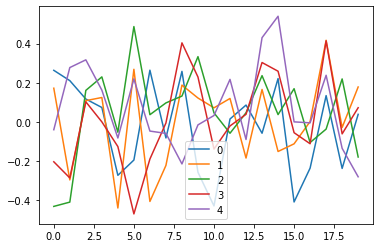

In [219]:

for i in range(5):
    print(np.argsort(Ws[i]))
    plt.plot(Ws[i]/np.linalg.norm(Ws[i]),label=i)
plt.legend()


17 8 5 13 14

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


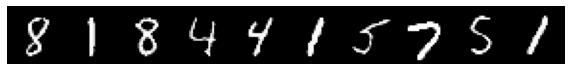

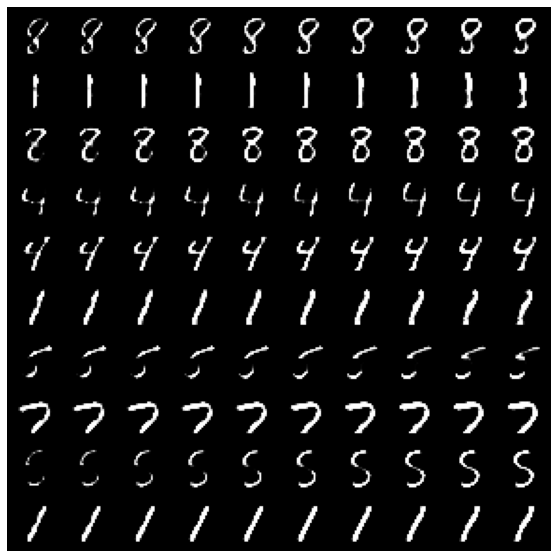

In [272]:
S = [2, 4, 5, 6, 10, 13, 16, 17, 18, 19]
Sc = list(set(range(20))-set(S))

for it, (images, labels) in enumerate(train_loader):
    
    nsamples = 10
    images = images[:nsamples]
    labels = labels[:nsamples]
    labels = make_label(labels)
    images, labels = images.to(device), labels.to(device)
    _,_,z,_ = vae(images)
    
    npoints = 10
    grid = 0.5*torch.linspace(-1,1,steps=npoints).to(device)
    grid = grid.repeat(nsamples)
    
    z = z.repeat_interleave(npoints,dim=0)
    
    zgrid = z
    for s in Sc:
        zgrid[:,s] += grid
    
    y = vae.decoder(zgrid)
    
    
    imshow(torchvision.utils.make_grid(images.cpu().detach().view(-1,1,28,28),padding=1,nrow=10))
    imshow(torchvision.utils.make_grid(y.cpu().detach().view(-1,1,28,28),padding=1,nrow=10))
     
    
    break

In [271]:
def imshow(img):
    plt.figure(figsize=(10,10))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    
def torch_to_np(tensor):
    return tensor.cpu().detach().numpy()

    

In [254]:
z.size(), z.repeat_interleave(npoints,1).size()

(torch.Size([3, 200]), torch.Size([3, 2000]))